# 0 - IMPORTS AND CONSTANTS

All modules, imports, libraries and constant used in this file

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from seaborn import heatmap

# All the validation metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

# imports of class created by me
from ForestaRandomica import ForestaRandomica


INPUT_FILE_PATH = 'mnist_784.csv'
METRICS_PARAMETER={accuracy_score:None, recall_score:{'average':None}, precision_score:{'average':None}, f1_score:{'average':None}}


# 1 - DATA READING AND PARTITIONING

Load the MNIST dataset into memory. <br>
Divide the 70,000 digits you have into:
- training set (60,000 digits) 
- test set (10,000 digits).

In [154]:
def readMnistDataset(file:str)->pd.DataFrame:
    return pd.read_csv(filepath_or_buffer=file, header=0).rename(columns={'class':'label'})

# 2 - SINGLE RANDOM TREE

Train a single decision tree (with the default parameters) on the training set, then compute its
accuracy on the test set.

In [155]:
def computeMetrics(yTrue:pd.DataFrame, yPred:pd.DataFrame, metrics:list=METRICS_PARAMETER,
                    printMap: bool=False)->dict[str:float]:
    if printMap:
        fig, ax = plt.subplots(1,1,figsize=(12,12))
        heatmap(confusion_matrix(yTrue, yPred), annot=True, ax=ax)
        plt.show()
    
    val = pd.DataFrame({str(metric).split()[1]:(metric(yTrue, yPred, **metrics[metric])if metrics[metric] else metric(yTrue, yPred))*100
            for metric in metrics})
    
    return (pd.concat([val, val.agg(func=['mean', 'min', 'max', 'std'], axis=0)], axis=0)
            .map(lambda x: x if not isinstance(x, float) else (round(x, 3) if x > 1e-6 else 0)))

def createAndTestSingleRandomTree(xTrain:pd.DataFrame, xTest:pd.DataFrame, yTrain:pd.DataFrame, yTest:pd.DataFrame, 
                                metrics:list=METRICS_PARAMETER, printMap: bool=False)->dict[str:float]:
    
    return computeMetrics(yTest, DecisionTreeClassifier().fit(xTrain, yTrain).predict(xTest),
                            metrics=metrics, printMap=printMap)
    

# 3 - MY OWN RANDOM FOREST

Was implemented in the class ForestaRandomica.<br>
This function just tests it

# 4 - TEST MY RANDOM FOREST

Now train your random forest with the 60,000 points of the training set and compute its accuracy
against the test set. How does the random forest behave? How does it compare to a decision tree? <br>
How does this performance vary as the number of estimators grow? Try values from 10 to 100 (with
steps of 10) for n_estimators.

In [ ]:
def testMyOwnRandomForest(xTrain:pd.DataFrame, xTest:pd.DataFrame, yTrain:pd.DataFrame, yTest:pd.DataFrame, 
                        estimators:int=10)->None:
    print(f"FINAL RESULTS OF MY RANDOM FOREST OF {estimators} TREES")
    return computeMetrics(yTest, ForestaRandomica(nEstimators=estimators).fit(xTrain, yTrain) , printMap=True)
    

# MAIN FUNCTION

This is the main function of the program, it does the following things:
<ol>
<li>Reads the mnist dataset and partitions it</li>
<li>Trains a single decision tree and test it's accuracy</li>
<li>Try implementing a random forest classifier</li>
<li></li>
<li></li>
<li></li>
<li></li>
</ol> 

FINAL RESULTS OF A SINGLE DECISION TREE :


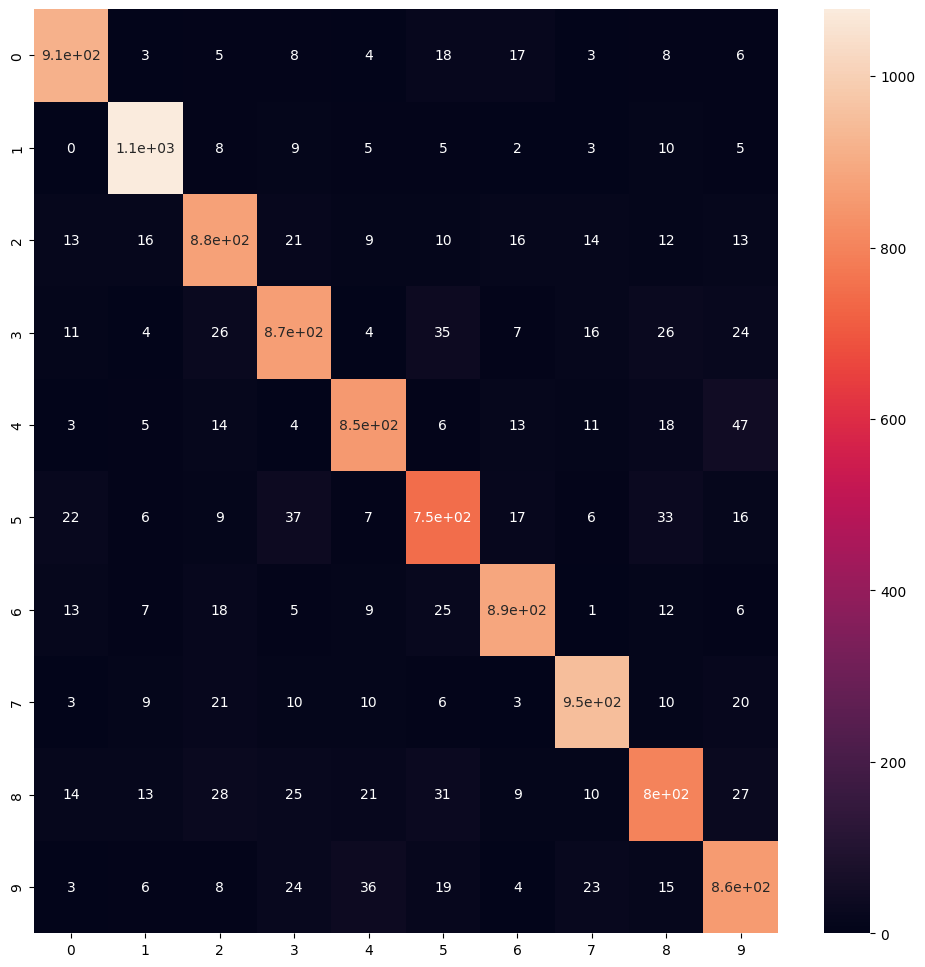

,accuracy_score,recall_score,precision_score,f1_score
0,88.26,92.698,91.767,92.230
1,88.26,95.822,93.984,94.894
2,88.26,87.588,86.462,87.021
3,88.26,85.000,85.842,85.419
4,88.26,87.590,89.051,88.314
5,88.26,83.038,82.854,82.946
6,88.26,90.224,90.965,90.593
7,88.26,91.171,91.610,91.390
8,88.26,81.744,84.697,83.194
9,88.26,86.117,83.922,85.005


FINAL RESULTS OF MY RANDOM FOREST OF 5 TREES


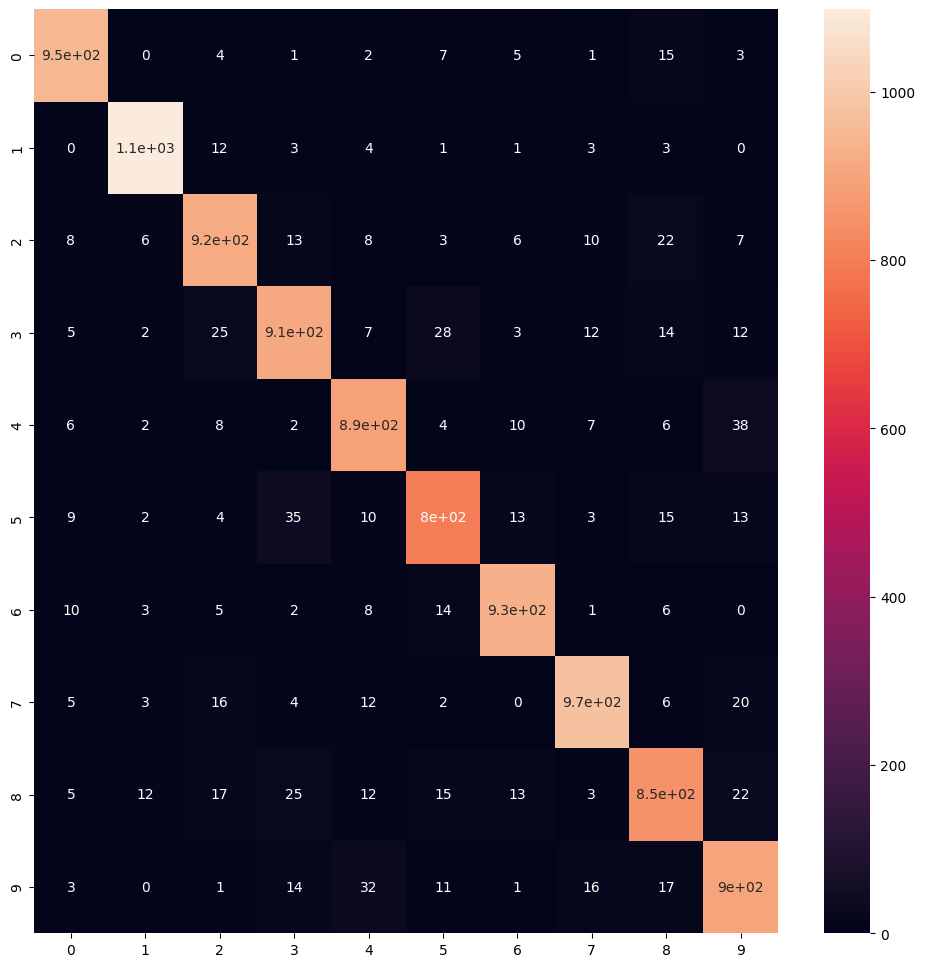

,accuracy_score,recall_score,precision_score,f1_score
0,92.21,96.146,94.895,95.516
1,92.21,97.600,97.340,97.470
2,92.21,91.692,90.873,91.281
3,92.21,89.412,90.208,89.808
4,92.21,91.487,90.375,90.928
5,92.21,88.470,90.374,89.412
6,92.21,95.010,94.721,94.865
7,92.21,93.474,94.563,94.015
8,92.21,87.282,89.110,88.187
9,92.21,90.443,88.659,89.542


In [ ]:
def main()->None:
    df = readMnistDataset(INPUT_FILE_PATH) # 1
    xTrain, xTest, yTrain, yTest = train_test_split(df.loc[:, df.columns.difference({'label'})], 
                                                    df['label'], test_size=1/7, shuffle=True, stratify=df['label']) # 1
    
    print("FINAL RESULTS OF A SINGLE DECISION TREE :") # 2
    display(createAndTestSingleRandomTree(xTrain, xTest, yTrain, yTest, printMap=True)) # 2
    
    # 3 check class ForestaRandomica
    
    for estimators in range(10, 100, 10):
        testMyOwnRandomForest(xTrain, xTest, yTrain, yTest, estimators)
    
    

main()